# Setup Notebook

In [1]:
# When working in AI LRZ
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%run analysis_setup_cp.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The data has N = 900 rows and N = 14 columns.


## Prepare Data


In [3]:
import pandas as pd
from pathlib import Path

RUN_TO_ANALYSE = "14"
CP_DIR = Path("output") / "runs" / str(RUN_TO_ANALYSE)

df_agg = pd.read_csv(CP_DIR / "combined_cp_metrics.csv")

In [4]:
df_agg.head()

,universe_id,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size,cov_frau1,cov_nongerman,cov_nongerman_male,cov_nongerman_female
0,29bbfc090457b375162cd6d5988a0c0d,2010_14,1k,scale,rf,nationality-sex,drop-non-german,0.640000,0.913900,1.149827,0.911336,0.902824,0.923264,0.869001
1,f7207e98f9209b278fafa387f90cc17e,2010_14,25k,scale,rf,nationality-sex,drop-non-german,0.650000,0.914335,1.140999,0.912684,0.908774,0.923444,0.884501
2,621e12d5accc50ee57a82fe038d6e66d,2012_14,1k,do-not-scale,elasticnet,nationality-sex,keep-all,0.697848,0.911860,1.232828,0.909179,0.945209,0.955327,0.928465
3,523b4d52292fbf0322ce0d3ad7b649bd,2014,1k,do-not-scale,elasticnet,none,drop-non-german,0.677181,0.910144,1.251577,0.909476,0.947679,0.956859,0.932489
4,346c04ceb92e7cd7c01293712a413e02,2012_14,5k,do-not-scale,penalized_logreg,age,keep-all,0.665430,0.912596,1.250184,0.909341,0.960141,0.967396,0.948137


In [5]:
df_agg.shape

(900, 14)

In [6]:
main_cp_metric = "avg_size" # "avg_size", "cov_nongerman_female"

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [7]:
cols_design_dec = ["universe_training_year", 
                   "universe_training_size", 
                   "universe_scale",
                   "universe_model", 
                   "universe_exclude_features", 
                   "universe_exclude_subgroups"]
X = df_agg[cols_design_dec]
y = df_agg[main_cp_metric]

In [8]:
X.head()

,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups
0,2010_14,1k,scale,rf,nationality-sex,drop-non-german
1,2010_14,25k,scale,rf,nationality-sex,drop-non-german
2,2012_14,1k,do-not-scale,elasticnet,nationality-sex,keep-all
3,2014,1k,do-not-scale,elasticnet,none,drop-non-german
4,2012_14,5k,do-not-scale,penalized_logreg,age,keep-all


In [9]:
X.shape

(900, 6)

In [10]:
y.shape

(900,)

### Main Effects of Settings Only (i.e. no interactions)

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), 
).fit(X) 
X_processed = preprocessor.transform(X) 

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.678858679193476

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [12]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.146,<BIAS>
+0.054,universe_training_size_1k
+0.025,universe_scale_do-not-scale
+0.018,universe_exclude_features_age
+0.018,universe_model_logreg
+0.018,universe_model_penalized_logreg
+0.006,universe_exclude_subgroups_drop-non-german
+0.001,universe_training_year_2010_14
-0.000,universe_scale_scale
-0.000,universe_exclude_subgroups_keep-all


### Including Interactions

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.9009535239145172

Weights of importance:

In [14]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.151,<BIAS>
+0.040,universe_scale_do-not-scale universe_model_penalized_logreg
+0.040,universe_scale_do-not-scale universe_model_logreg
+0.038,universe_training_size_1k
+0.031,universe_scale_do-not-scale universe_exclude_features_age
+0.031,universe_training_size_1k universe_scale_scale
+0.023,universe_training_size_1k universe_model_elasticnet
+0.019,universe_model_elasticnet universe_exclude_features_age
+0.010,universe_training_size_1k universe_exclude_subgroups_drop-non-german
+0.005,universe_training_year_2012_14 universe_training_size_1k


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [15]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[cols_design_dec], outcome = df_agg[main_cp_metric])


In [16]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.024364,0.024364,0.003222,0.003222
universe_exclude_subgroups,0.004381,0.004381,0.000815,0.000815
universe_model,0.243252,0.243252,0.007816,0.007816
universe_scale,0.067718,0.067718,0.002848,0.002848
universe_training_size,0.335965,0.335965,0.006585,0.006585
universe_training_year,0.000640,0.000640,0.000245,0.000245


In [17]:
m_fanova.quantify_importance(save_to = CP_DIR/ f"fanova_importance_interactions-overall_{main_cp_metric}.csv")

,level_0,level_1,level_2,level_3,level_4,level_5,individual importance,total importance,individual std,total std
4,universe_training_size,NaN,NaN,NaN,NaN,NaN,0.335965,0.335965,0.006585,0.006585
2,universe_model,NaN,NaN,NaN,NaN,NaN,0.243252,0.243252,0.007816,0.007816
16,universe_model,universe_training_size,NaN,NaN,NaN,NaN,0.075887,0.655103,0.002998,0.008481
3,universe_scale,NaN,NaN,NaN,NaN,NaN,0.067718,0.067718,0.002848,0.002848
15,universe_model,universe_scale,NaN,NaN,NaN,NaN,0.055357,0.366327,0.003608,0.010235
...,...,...,...,...,...,...,...,...,...,...
14,universe_exclude_subgroups,universe_training_year,NaN,NaN,NaN,NaN,0.000165,0.005186,0.000163,0.000822
24,universe_exclude_features,universe_exclude_subgroups,universe_training_year,NaN,NaN,NaN,0.000163,0.030348,0.000253,0.003072
35,universe_exclude_subgroups,universe_scale,universe_training_year,NaN,NaN,NaN,0.000163,0.074353,0.000131,0.002432
45,universe_exclude_features,universe_exclude_subgroups,universe_scale,universe_training_year,NaN,NaN,0.000138,0.117328,0.000224,0.006877


In [18]:
# Latex Table "10 most important decisions or decision interactions"

pd.set_option('display.max_colwidth', None)  

fanova_df = m_fanova.quantify_importance()

top10 = (
    fanova_df
    .sort_values('individual importance', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Detect main vs. N-way interaction
def effect_type(row):
    levels = [row[f'level_{i}'] for i in range(5) if pd.notna(row.get(f'level_{i}'))]
    return 'main' if len(levels) == 1 else f'{len(levels)}-way int.'

top10['Effect Type'] = top10.apply(effect_type, axis=1)

def clean_level(name: str) -> str:
    if pd.isna(name): 
        return ""
    # strip leading universe_
    if name.startswith("universe_"):
        name = name[len("universe_"):]
    # snake_case → CamelCase
    return "".join(part.capitalize() for part in name.split("_"))

def fmt_level(name: str) -> str:
    return f"\\textit{{{clean_level(name)}}}"

top10["Decision / Interaction of Decisions"] = (
    top10
    .apply(
        lambda row: " $\\times$ ".join(
            fmt_level(row[f"level_{i}"])
            for i in range(5)                      # loop over 0–4
            if pd.notna(row.get(f"level_{i}"))
        ),
        axis=1,
    )
)

out = top10[[
    'Effect Type',
    'Decision / Interaction of Decisions',
    'individual importance',
    'individual std'
]].copy()
out.columns = [
    'Effect Type',
    'Decision / Interaction of Decisions',
    'Importance',
    'Std. Deviation'
]

out['Importance']    = out['Importance'].round(3)
out['Std. Deviation']= out['Std. Deviation'].round(3)

raw = out.to_latex(
    index=False,
    escape=False,       
    column_format='llrr'
)

lines = raw.splitlines()
new_lines = []
hcount = 0
for ln in lines:
    if ln.strip() == r'\hline':
        hcount += 1
        if hcount == 1:
            new_lines.append(r'\toprule')
        elif hcount == 2:
            new_lines.append(r'\midrule')
        else:
            new_lines.append(r'\bottomrule')
    else:
        new_lines.append(ln)
fixed_tabular = "\n".join(new_lines)

# 9. wrap in full table environment
latex = f"""\\begin{{table}}
\\centering
\\caption{{The 10 most important decisions or decision interactions and their relative importance for the average prediction set size.}}
\\label{{tab:fanova_top10}}
{fixed_tabular}
\\end{{table}}
"""

output_path = CP_DIR / f"fanova_top10_{main_cp_metric}.tex"
output_path.write_text(latex)

/tmp/ipykernel_1582228/888124175.py:61: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  raw = out.to_latex(


1571

# Visualizations

In [43]:
# 5 most important 2-way interactions
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('universe_model', 'universe_training_size'), 0.07588652287248818), (('universe_model', 'universe_scale'), 0.05535722448640056), (('universe_scale', 'universe_training_size'), 0.0481565387384776), (('universe_exclude_features', 'universe_scale'), 0.017304168683210892), (('universe_exclude_features', 'universe_model'), 0.01465907903294241)])


In [44]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(CP_DIR))

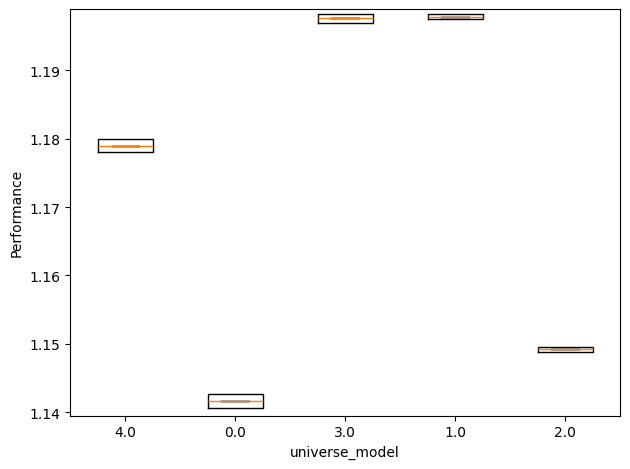

In [63]:
# Plot 1D marginal
vis.plot_marginal(2)

In [54]:
# Recover mapping for 'universe_training_size'
col = "universe_training_size"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)


{0: '1k', 1: '25k', 2: '5k'}


/tmp/ipykernel_1582228/884858384.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1582228/884858384.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(


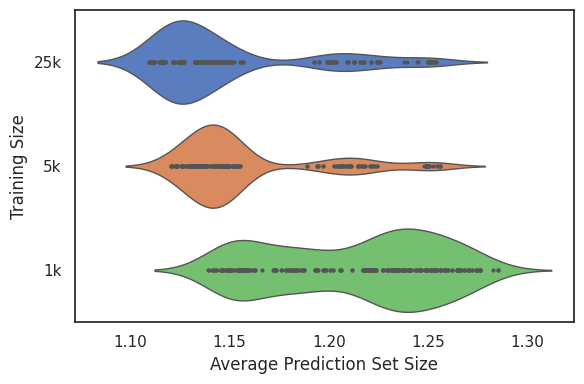

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Define your mapping and desired order (bottom to top)
label_map = {
    0: "1k",
    1: "25k",
    2: "5k"
}
desired_order = ["25k", "5k", "1k"]  # bottom to top

# 2. Prep data
param = "universe_training_size"
target = main_cp_metric
df_plot = df_agg[[param, target]].copy()
df_plot[param] = df_plot[param].map(lambda x: label_map.get(x, x))
df_plot[param] = pd.Categorical(df_plot[param], categories=desired_order, ordered=True)

# 3. Plot
plt.figure(figsize=(6, 4))
sns.violinplot(
    data=df_plot,
    y=param,
    x=target,
    order=desired_order,      # explicitly enforce order
    palette="muted",
    scale="area",
    inner="point",
    linewidth=1
)
plt.xlabel("Average Prediction Set Size")
plt.ylabel("Training Size")
#plt.title("Training Size")
plt.tight_layout()
plt.show()


/tmp/ipykernel_1582228/141865952.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, y="Model", x="Prediction", order=order,


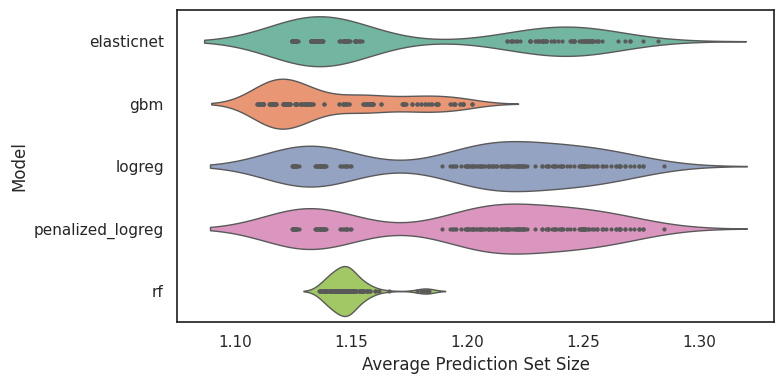

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the relevant columns
param = "universe_model"
df_plot = df_agg[[param, main_cp_metric]].copy()
df_plot.columns = ["Model", "Prediction"]

# Optional: Order models as you like (alphabetical or custom)
order = sorted(df_plot["Model"].unique())  # or provide manually
plt.figure(figsize=(8, 4))
sns.violinplot(data=df_plot, y="Model", x="Prediction", order=order,
               palette="Set2", inner="point", linewidth=1)

plt.xlabel("Average Prediction Set Size")
plt.ylabel("Model")
#plt.title("Model")
plt.tight_layout()
plt.show()


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

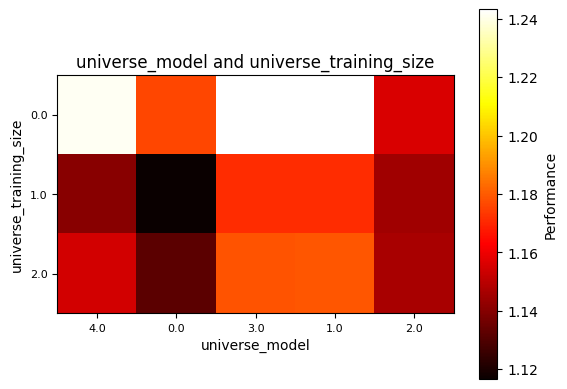

In [30]:
# Plot 2D pairwise marginal
vis.plot_pairwise_marginal(['universe_model', 'universe_training_size'])

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

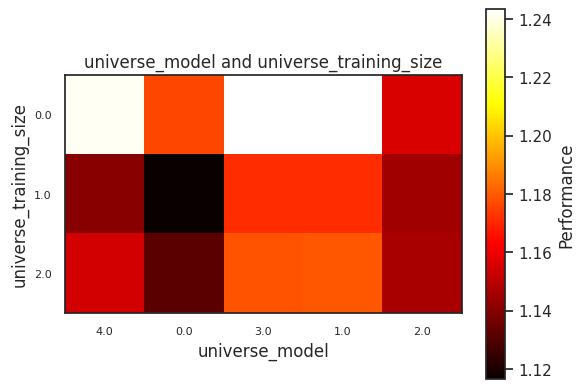

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1: Extract grid from the visualizer ---
grid = vis.plot_pairwise_marginal(['universe_model', 'universe_training_size'])

# --- STEP 2: Label maps ---
model_label_map = {0: 'elasticnet', 1: 'gbm', 2: 'logreg', 3: 'pen_logreg', 4: 'rf'}
training_label_map = {0: '1k', 1: '25k', 2: '5k'}

# --- STEP 3: Format axis labels ---
x_labels = [model_label_map[i] for i in sorted(model_label_map)]
y_labels = [training_label_map[i] for i in sorted(training_label_map, reverse=True)]

# --- STEP 4: Create grid DataFrame and flip rows to match heatmap view ---
grid_array = np.array(grid)
df_grid = pd.DataFrame(grid_array[::-1], index=y_labels, columns=x_labels)

# --- STEP 5: Plot with annotations ---
plt.figure(figsize=(7, 4))
sns.heatmap(df_grid, annot=True, fmt=".2f", cmap="hot", cbar_kws={'label': 'Performance'})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel("Model")
plt.ylabel("Training Size")
plt.title("Model × Training Size (fANOVA Predictions)")
plt.tight_layout()
plt.show()


In [104]:
grid

<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [86]:
# Recover mapping
col = "universe_training_size"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)

{0: '1k', 1: '25k', 2: '5k'}


In [85]:
# Recover mapping
col = "universe_model"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)

{0: 'elasticnet', 1: 'gbm', 2: 'logreg', 3: 'penalized_logreg', 4: 'rf'}


In [87]:
x_labels

['elasticnet', 'gbm', 'logreg', 'penalized_logreg', 'rf']

In [88]:
y_labels

['1k', '25k', '5k']

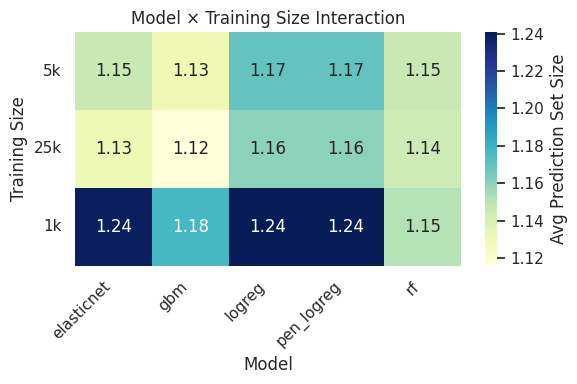

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define parameter names
#param_x = "universe_model"
#param_y = "universe_training_size"
#
## Get sorted categories
#x_labels = sorted(df_agg[param_x].unique())
#y_labels = sorted(df_agg[param_y].unique())
#
## Fill grid: rows = y (training), cols = x (model)
#grid = np.zeros((len(y_labels), len(x_labels)))
#
#for i, y in enumerate(y_labels):
#    for j, x in enumerate(x_labels):
#        subset = df_agg[(df_agg[param_x] == x) & (df_agg[param_y] == y)]
#        grid[i, j] = subset[main_cp_metric].median()  # alternative mean()

# Use label maps to map back from integer to string labels
model_label_map = {0: 'elasticnet', 1: 'gbm', 2: 'logreg', 3: 'pen_logreg', 4: 'rf'}
training_label_map = {0: '1k', 1: '25k', 2: '5k'}

# Create sorted lists of labels based on the label maps
x_labels_display = [model_label_map[i] for i in sorted(model_label_map)]
y_labels_display = [training_label_map[i] for i in sorted(training_label_map)]


# Reorder y for bottom-up layout
df_grid = pd.DataFrame(grid[::-1], index=y_labels_display[::-1], columns=x_labels_display)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(df_grid, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Prediction Set Size'})
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Model")
plt.ylabel("Training Size")
plt.title("Model × Training Size Interaction")
plt.tight_layout()
plt.show()


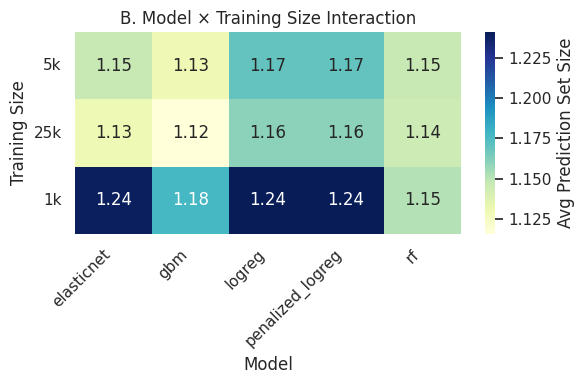

In [93]:
from sklearn.preprocessing import LabelEncoder

# Recover model label mapping
col_model = "universe_model"
le_model = LabelEncoder()
le_model.fit(df_agg[col_model].values)
model_label_map = dict(zip(le_model.transform(le_model.classes_), le_model.classes_))

# Recover training size label mapping
col_train = "universe_training_size"
le_train = LabelEncoder()
le_train.fit(df_agg[col_train].values)
train_label_map = dict(zip(le_train.transform(le_train.classes_), le_train.classes_))

# Sort labels by code
x_labels_display = [model_label_map[i] for i in sorted(model_label_map)]
y_labels_display = [train_label_map[i] for i in sorted(train_label_map)]

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reorder if needed (put smallest training size at the bottom)
df_grid = pd.DataFrame(grid[::-1], index=y_labels_display[::-1], columns=x_labels_display)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(df_grid, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Prediction Set Size'})
plt.xlabel("Model")
plt.ylabel("Training Size")
plt.title("B. Model × Training Size Interaction")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

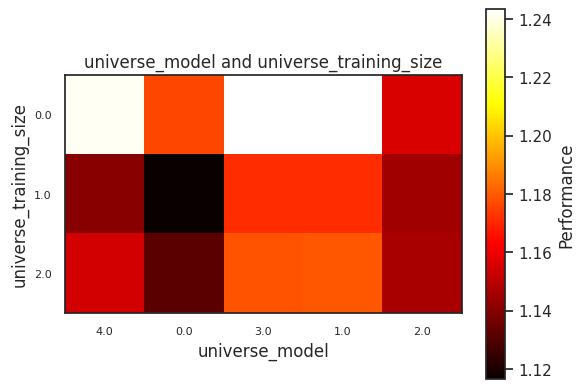

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Force the plot to render and extract the grid (internally stored)
grid = vis.plot_pairwise_marginal(['universe_model', 'universe_training_size'])

# Map from numeric indices to meaningful labels
model_label_map = {0: 'elasticnet', 1: 'gbm', 2: 'logreg', 3: 'pen_logreg', 4: 'rf'}
training_label_map = {0: '1k', 1: '25k', 2: '5k'}

# Extract and reorder axis labels
x_labels_display = [model_label_map[i] for i in sorted(model_label_map)]
y_labels_display = [training_label_map[i] for i in sorted(training_label_map, reverse=True)]

# Convert grid to a DataFrame with proper axis labels
df_grid = pd.DataFrame(np.array(grid)[::-1], index=y_labels_display, columns=x_labels_display)

# Plot the nicely formatted heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_grid, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Prediction Set Size'})
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Model")
plt.ylabel("Training Size")
plt.title("B. Model × Training Size Interaction")
plt.tight_layout()
plt.show()


## Quantify Importance with Partial Data

In [ ]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [ ]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)